# Load Data & Inspect

In [2]:
import pandas as pd
%matplotlib inline

In [141]:
cards = pd.read_csv('tj_01_creditcard_card.csv')
customers = pd.read_csv('tj_01_creditcard_customer.csv')
transactions = pd.read_csv('tj_01_creditcard_transaction.csv')

testdata = pd.read_csv('tj_01_test.csv', header=None)
traindata = pd.read_csv('tj_01_training.csv', header=None)

In [142]:
traindata.columns = ['card_no', 'npl_flag']
testdata.columns = ['card_no']

In [143]:
# Merge card and customers
card_customers = cards.merge(customers, how='left', on='cst_id')

In [144]:
card_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11875 entries, 0 to 11874
Data columns (total 13 columns):
card_no            11875 non-null int64
bill_cyc           11875 non-null int64
pos_dt_x           11875 non-null object
cst_id             11875 non-null int64
open_dt            11875 non-null object
exp_dt             11875 non-null int64
cr_lmt_amt         11875 non-null float64
prev_cr_lmt_amt    11875 non-null float64
incm_amt           11875 non-null int64
age                11874 non-null float64
main_zip_cd        11875 non-null int64
cr_line_amt        11875 non-null float64
pos_dt_y           11875 non-null object
dtypes: float64(4), int64(6), object(3)
memory usage: 1.3+ MB


## Create features from transactions

In [145]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627291 entries, 0 to 627290
Data columns (total 6 columns):
card_no         627291 non-null int64
txn_date        627291 non-null object
txn_hour        627291 non-null int64
txn_amount      627291 non-null float64
mer_cat_code    627291 non-null int64
mer_id          627291 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 28.7+ MB


In [146]:
transactions.head()

,card_no,txn_date,txn_hour,txn_amount,mer_cat_code,mer_id
0,1234000000010196,2016-08-03 00:00:00,19,250.0,5411,0
1,1234000000020315,2016-08-03 00:00:00,19,400.0,6300,0
2,1234000000013283,2016-08-03 00:00:00,19,500.0,6300,0
3,1234000000027192,2016-08-03 00:00:00,19,50.0,7832,0
4,1234000000006620,2016-08-03 00:00:00,19,1300.0,5812,0


In [151]:
tgroup = transactions[['card_no', 'txn_amount']].groupby('card_no').agg(['mean', 'count', 'sum'])

tgroup_df = pd.DataFrame({
    'tran_mean': tgroup['txn_amount']['mean'],
    'tran_count': tgroup['txn_amount']['count'],
    'tran_sum': tgroup['txn_amount']['sum']
})

tgroup_df = tgroup_df.reset_index()

tgroup_df.head()

,card_no,tran_count,tran_mean,tran_sum
0,1234000000000004,43,905.813953,38950.0
1,1234000000000005,7,178.571429,1250.0
2,1234000000000006,32,3525.000000,112800.0
3,1234000000000010,71,423.239437,30050.0
4,1234000000000012,40,1481.250000,59250.0


In [152]:
# Merge all deposits features
card_fulldata = card_customers.merge(tgroup_df, how='left', on='card_no')
card_fulldata = card_fulldata.fillna(0)
card_fulldata.head()

,card_no,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y,tran_count,tran_mean,tran_sum
0,1234000000023349,20,2017-02-23 00:00:00,1000004674,2010-12-20 00:00:00,1220,70000.0,0.0,58650,67.0,10310,140000.0,2017-02-23 00:00:00,82,436.585366,35800.0
1,1234000000007292,17,2017-02-23 00:00:00,1000010084,2014-06-04 00:00:00,619,69000.0,60000.0,19989,25.0,10150,69000.0,2017-02-23 00:00:00,56,442.857143,24800.0
2,1234000000018889,20,2017-02-23 00:00:00,1000009114,2014-01-22 00:00:00,119,27000.0,32000.0,18257,45.0,20110,27000.0,2017-02-23 00:00:00,143,328.321678,46950.0
3,1234000000016887,17,2017-02-23 00:00:00,1000013313,2015-12-03 00:00:00,1220,41000.0,0.0,20881,55.0,56000,41000.0,2017-02-23 00:00:00,148,366.216216,54200.0
4,1234000000026997,17,2017-02-23 00:00:00,1000010235,2014-06-24 00:00:00,619,50000.0,60000.0,28956,27.0,10110,50000.0,2017-02-23 00:00:00,35,1767.142857,61850.0


In [153]:
# Create more features
card_fulldata['cr_diff'] = card_fulldata['cr_lmt_amt'] - card_fulldata['prev_cr_lmt_amt']

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(card_fulldata['main_zip_cd'])
card_fulldata['zip_encode'] = encoder.transform( card_fulldata['main_zip_cd'] )

In [190]:
# Create agegroup
card_fulldata['agegroup'] = (pd.cut(card_fulldata['age'], bins=[0,10,20,30,40,50,60,70,80,90], labels=[0,10,20,30,40,50,60,70,80])).astype(int)
card_fulldata.head()

,card_no,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y,tran_count,tran_mean,tran_sum,cr_diff,zip_encode,agegroup
0,1234000000023349,20,2017-02-23 00:00:00,1000004674,2010-12-20 00:00:00,1220,70000.0,0.0,58650,67.0,10310,140000.0,2017-02-23 00:00:00,82,436.585366,35800.0,70000.0,20,60
1,1234000000007292,17,2017-02-23 00:00:00,1000010084,2014-06-04 00:00:00,619,69000.0,60000.0,19989,25.0,10150,69000.0,2017-02-23 00:00:00,56,442.857143,24800.0,9000.0,6,20
2,1234000000018889,20,2017-02-23 00:00:00,1000009114,2014-01-22 00:00:00,119,27000.0,32000.0,18257,45.0,20110,27000.0,2017-02-23 00:00:00,143,328.321678,46950.0,-5000.0,111,40
3,1234000000016887,17,2017-02-23 00:00:00,1000013313,2015-12-03 00:00:00,1220,41000.0,0.0,20881,55.0,56000,41000.0,2017-02-23 00:00:00,148,366.216216,54200.0,41000.0,369,50
4,1234000000026997,17,2017-02-23 00:00:00,1000010235,2014-06-24 00:00:00,619,50000.0,60000.0,28956,27.0,10110,50000.0,2017-02-23 00:00:00,35,1767.142857,61850.0,-10000.0,2,20


In [191]:
ctab = pd.crosstab(card_fulldata['agegroup'], traindata_full['npl_flag'])

In [192]:
ctab['ratio'] = ctab[1] / (ctab[1] + ctab[0])

In [193]:
ctab['agegroup'] = ctab.index.values

In [194]:
ctab

npl_flag,0.0,1.0,ratio,agegroup
agegroup,,,,
20,1041,432,0.293279,20
30,2589,1019,0.282428,30
40,1866,702,0.273364,40
50,981,397,0.288099,50
60,289,128,0.306954,60
70,32,20,0.384615,70
80,1,1,0.500000,80


## Combine test & train data

In [195]:
# # Log Transform
# import numpy as np
# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)

# acc_fulldata['cr_mean_lg'] = transformer.transform(acc_fulldata['cr_mean'].values.reshape(-1, 1))
# acc_fulldata['cr_sum_lg'] = transformer.transform(acc_fulldata['cr_sum'].values.reshape(-1, 1))
# acc_fulldata['dr_mean_lg'] = transformer.transform(acc_fulldata['dr_mean'].values.reshape(-1, 1))
# acc_fulldata['dr_sum_lg'] = transformer.transform(acc_fulldata['dr_sum'].values.reshape(-1, 1))
# acc_fulldata['cr_outside_sum_lg'] = transformer.transform(acc_fulldata['cr_outside_sum'].values.reshape(-1, 1))
# acc_fulldata['dr_outside_sum_lg'] = transformer.transform(acc_fulldata['dr_outside_sum'].values.reshape(-1, 1))
# acc_fulldata['dorm_mean_lg'] = transformer.transform(acc_fulldata['dorm_mean'].values.reshape(-1, 1))
# acc_fulldata['dorm_sum_lg'] = transformer.transform(acc_fulldata['dorm_sum'].values.reshape(-1, 1))

In [196]:
traindata_full = traindata.merge(card_fulldata, how='left', on='card_no')
testdata_full = testdata.merge(card_fulldata, how='left', on='card_no')

In [197]:
traindata_full.head()

,card_no,npl_flag,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y,tran_count,tran_mean,tran_sum,cr_diff,zip_encode,agegroup
0,1234000000017866,0,5,2017-02-23 00:00:00,1000001917,2011-08-18 00:00:00,821,120000.0,140000.0,163591,36.0,72110,120000.0,2017-02-23 00:00:00,70,1847.857143,129350.0,-20000.0,455,30
1,1234000000023670,1,20,2017-02-23 00:00:00,1000012033,2015-05-18 00:00:00,520,90000.0,108000.0,90143,57.0,10510,90000.0,2017-02-23 00:00:00,31,529.032258,16400.0,-18000.0,25,50
2,1234000000012719,0,25,2017-02-23 00:00:00,1000002796,2010-01-23 00:00:00,119,300000.0,500000.0,120000,56.0,10250,300000.0,2017-02-23 00:00:00,19,736.842105,14000.0,-200000.0,14,50
3,1234000000021503,0,10,2017-02-23 00:00:00,1000010792,2014-09-30 00:00:00,919,20000.0,0.0,16000,29.0,51180,20000.0,2017-02-23 00:00:00,33,653.030303,21550.0,20000.0,351,20
4,1234000000010310,0,20,2017-02-23 00:00:00,1000009333,2014-02-25 00:00:00,219,20000.0,0.0,16281,26.0,10310,20000.0,2017-02-23 00:00:00,41,254.878049,10450.0,20000.0,20,20


In [198]:
testdata_full.head()

,card_no,bill_cyc,pos_dt_x,cst_id,open_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,incm_amt,age,main_zip_cd,cr_line_amt,pos_dt_y,tran_count,tran_mean,tran_sum,cr_diff,zip_encode,agegroup
0,1234000000018444,20,2017-02-23 00:00:00,1000006115,2011-07-22 00:00:00,721,80000.0,0.0,33780,39.0,10230,80000.0,2017-02-23 00:00:00,106,663.679245,70350.0,80000.0,12,30
1,1234000000014024,20,2017-02-23 00:00:00,1000007567,2014-11-21 00:00:00,1119,90000.0,0.0,60581,39.0,10280,90000.0,2017-02-23 00:00:00,84,1542.261905,129550.0,90000.0,17,30
2,1234000000018965,5,2017-02-23 00:00:00,1000004268,2010-06-11 00:00:00,620,263000.0,315600.0,105410,52.0,10250,263000.0,2017-02-23 00:00:00,46,2254.347826,103700.0,-52600.0,14,50
3,1234000000012493,17,2017-02-23 00:00:00,1000004262,2010-06-10 00:00:00,620,196000.0,197700.0,78540,45.0,10140,196000.0,2017-02-23 00:00:00,150,689.666667,103450.0,-1700.0,5,40
4,1234000000026521,25,2017-02-23 00:00:00,1000003497,2014-12-02 00:00:00,1219,280000.0,288000.0,94220,62.0,10240,280000.0,2017-02-23 00:00:00,52,2350.961538,122250.0,-8000.0,13,60


## Predict

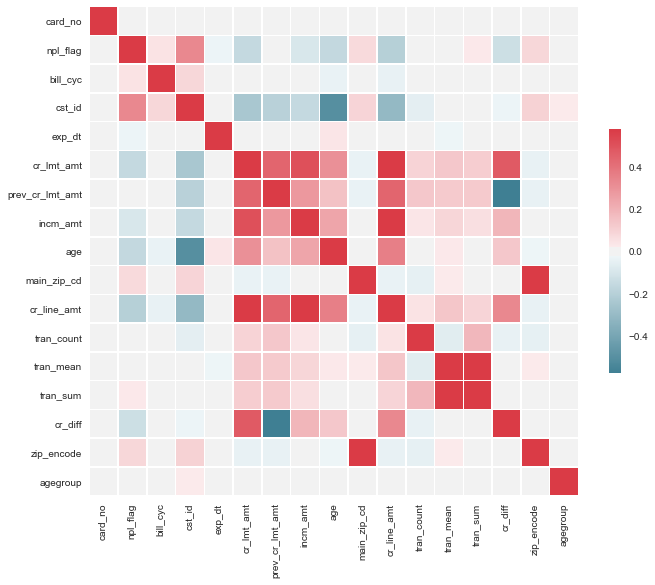

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = traindata_full.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [200]:
# Predict
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

In [215]:
# Settings
use_columns = [
    'bill_cyc',
    'cr_diff',
    'cr_lmt_amt',
    'zip_encode',
    'cr_line_amt',
    'tran_count',
    'tran_sum',
    'age'
]

target_column = 'npl_flag'

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

# from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)

# from sklearn import svm
# model = svm.SVC(C=10, gamma=0.01)

# model = XGBClassifier(max_depth=5)

testsze = 0.3

In [216]:
# Test Model
x_train, x_test, y_train, y_test = train_test_split(
    traindata_full[use_columns],
    traindata_full[target_column], test_size = testsze)

estimator = model.fit(x_train, y_train)

np.mean(cross_val_score(estimator, x_test, y_test, cv=10))

0.75721890168146655

In [140]:
# # # Find Parameters

# from sklearn.model_selection import GridSearchCV

# # AdaBoost
# param_grid = {
#     'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.5,0.7,1],
#     'n_estimators':[10,30,50,70,100,200,500,1000]
# }
# model = AdaBoostClassifier()

# # SVM
# # Cs = [0.001, 0.01, 0.1, 1, 10]
# # gammas = [0.001, 0.01, 0.1, 1]
# # param_grid = {'C': Cs, 'gamma' : gammas}
# # model = svm.SVC()

# clf = GridSearchCV(model, param_grid)
# clf.fit(x_train, y_train)
# print(clf.best_params_)

In [206]:
# Find features important

# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(estimator, prefit=True)

# estimator.feature_importances_

array([ 0.06324463,  0.13874146,  0.10464314,  0.13919642,  0.13479677,
        0.1367693 ,  0.16508419,  0.1175241 ])

In [217]:
# Save File
predict_y = estimator.predict(testdata_full[use_columns])

np.savetxt('1.txt', predict_y, fmt="%d")